## Vamos a estudiar el hamiltoniano asociado a una cadena de moléculas con interacción dipolar. 

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from qutip import *

from qutip import (about, destroy, entropy_vn, expect, hinton, jmat, ptrace, qeye, steadystate, tensor, wigner)
from mpl_toolkits.mplot3d import Axes3D # hacer gráfico 3Dfrom numpy import *


%matplotlib inline 
plt.rcParams['figure.figsize'] = 15, 15 #ancho, alto
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) 

In [4]:
def a0(x): #esta función convierte una distancia x en metros a unidades atómicas a_0
    return x/(5.29177249e-11) 

def tau(t): #convertir de segundos a tiempo en unidades atómicas
    return t/2.418884332268184938e-17


def dby(d): #d está en debyes, pasamos a unidades atómocas ea_0
    return (d*0.393430307)


def fre(f): #se ingresa la frecuencia como energía en eV se convierte a hartrees. 
    
    return f/ 27.211386245988


def per(epsilon_r):
    epsilon_0=8.8541878176e-12
    return epsilon_0*epsilon_r/1.11265005545e-10

In [ ]:
M=31
N=5

In [200]:
#parámetros de la nano esfera
omega_p=fre(6.278) #se ingresa en eV, luego se transforma en Hartrees. 
R=a0(2e-9) #urgente determinar el R asociado a una frecuencia dada. 

#parámetros de las moléculas
omega_m=omega_p
epsilon_2=per(6.29) 

d=dby(1.411)  #el dipolo se ingresa en debyes

#paŕametros de la red

r=a0(6.27e-10)    # separación horizontal entre dipolos 

y=-(R+0.5*r)    #distancia vertical entre el centro de la nano esfera y la línea en dónde están ubicados 
#los dipolos 

In [6]:
d

0.555130163177

In [7]:
def posiciones(M,r,y):  #posiciones solo de una línea, da el vector desde el centro de masa hasta el 
    #centro de cada dipolo.   
    
    """
    Posiciones de los dipolos, el número de dipolos debe ser impar por la forma en la que se construye 
    la celda unitaria.
    """
    Dx=np.linspace(-(M-1)/2*r ,(M-1)/2*r,M)
    D=[]
    for i in range (len(Dx)):
        D.append([Dx[i], y, 0])
        
    return np.real(D)

# Función para encontrar los vectores aleatorios que definen cada momento

In [8]:
def Momentos(M): #función que entrega un vector que en cada componente tiene las componentes x,y,z 
    #del vector unitario que determina cada dipolo en una red de N dipolos.
    
    momentos=[]
    
    for i in range (M):
        #ahora vamos a determinar las direcciones aleatorias theta y phi de cada dipolo
        np.random.seed()
        theta=np.random.uniform(0, np.pi)
        phi=np.random.uniform(0, 2*np.pi)

        x1=np.sin(theta)*np.cos(phi)
        y1=np.sin(theta)*np.sin(phi)
        z1=np.cos(theta)

        momentos.append([x1,y1,z1]) #vector que en cada componente tiene en ángulo theta y phi asociado 
    return (np.real(momentos))

In [9]:
momentos=Momentos(M)
P=posiciones(M,r,y)

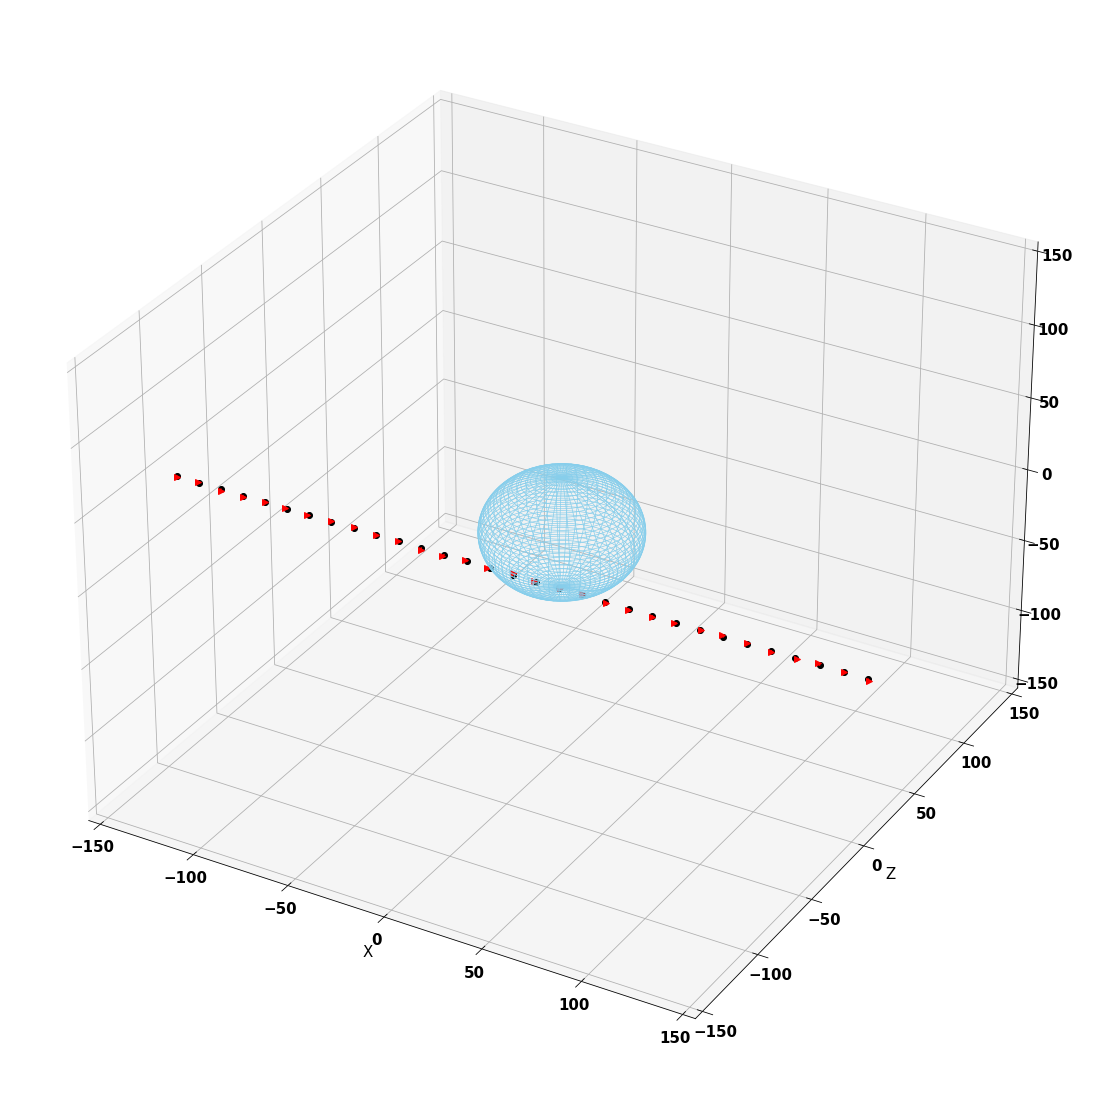

In [10]:
plt.rcParams['figure.figsize'] = 15, 15 #ancho, alto
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) 

fig=plt.figure()

ax = fig.add_axes([0, 0, 1, 1], projection='3d', auto_add_to_figure=False)


#graficamos la nanoesfera
theta=np.linspace(0,np.pi,100)
phi=np.linspace(0,2*np.pi,100)

Theta,Phi=np.meshgrid(theta,phi)

X=R*np.sin(Theta)*np.cos(Phi) 
Y=R*np.sin(Theta)*np.sin(Phi)
Z=R*np.cos(Theta)

ax.plot_wireframe(X,Y,Z,lw=0.7, color='skyblue') #dibujamos el casquete esférico


#graficamos los dipolos y su dirección
for i in range (len(P)): #en P están los centros de masa de los momentos
    #en momentos está el vector del momento. 
    
    x1=momentos[i][0]+P[i][0]
    y1=momentos[i][1]+P[i][1]
    z1=momentos[i][2]
    
    ax.plot((P[i][0],),(P[i][1],), (P[i][2],), marker='o',c='k') #dibujamos el centro del dipolo
    ax.plot((P[i][0], x1 ) ,(P[i][1],y1), (0,z1  ),  c='r') #dibujamos la línea
    ax.plot((x1,),(y1,),(z1,),'->',c='r') #dibujamos la dirección
    
 

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_ylabel('Z')
ax.set_xlim(-150,150)
ax.set_ylim(-150,150)
ax.set_zlim(-150,150)
plt.show()

# Función para determinar $\hat{\sigma}_+, \hat{\sigma}_-, \hat{\sigma}_3$ de cada dipolo

In [11]:
def sigmaT(M,N):
    l = 2  # number of levels per dipole
    Sigma = []
    for i in range(M):
        operators = []
        for j in range(M): #si el índice es igual a la matrix que quiero entonces pongo el destroy 
            #de resto pongo el qeye, luego al final pongo la matriz unitaria asociada a la radiación.
            if j != i:
                operators.append(qeye(l))
            else:
                operators.append(destroy(l))
        
        operators.append(qeye(N+1))
        sigma_plus=tensor(operators)
        Sigma.append(np.array(sigma_plus))

    return np.real(Sigma)

In [12]:
def Base(M,N):
    B=np.eye(2**M*(N+1))
    return np.linalg.eig(B)[1]

# Funciones para encontrar los vecinos

In [13]:
def vecinos(i, M):
    if i >= M:
        return "error"
    V = []
    if i != M - 1:
        V.append(i + 1)
    return V

In [14]:
def vecinosp(i, M):
    V=vecinos(i, M)
    if i==0: 
        V.append(M-1)       
    return V

# Función para determinar la energía de interacción entre dipolos

Energía de interacción asociada al dipolo $i$-ésimo. 

In [15]:
def Ein(i, M, Momentos, sigmas, u, p): 
    """
    Si u=1 es sin RWA, si es diferente de 1 es RWA.
    si p=1 las condiciones de frontera son no periódicas, si es diferente de 1 son periódicas.
    """ 
    
    if p==1: 
        V = vecinos(i, M)
    else:
        V = vecinosp(i, M)
        
    
    sum1 = 0
    sum2 = 0
    sum3 = 0
    
    s = sigmas[0].shape

    if M == 1:
        return np.zeros(s)
    
    
    if V:
        if u==1: 
            for k in V:
                sum1 += (sigmas[i] + np.transpose(sigmas[i])) @ (sigmas[k] + np.transpose(sigmas[k]))
                sum2 += np.dot(Momentos[i], Momentos[k])-3*np.dot(Momentos[i], [1,0,0])*np.dot(Momentos[k], [1,0,0])
            return sum2*sum1
        else:
            for k in V:
            
                sum3+= sigmas[i]@np.transpose(sigmas[k])+np.transpose(sigmas[i])@sigmas[k]
                sum2+= np.dot(Momentos[i], Momentos[k])-3*np.dot(Momentos[i], [1,0,0])*np.dot(Momentos[k], [1,0,0])

                return sum2*sum3
    else:
        return np.zeros(s)

# 

\begin{align}
    \hat{H}_{dip}= \frac{\omega_m}{2} \sum_{j=1}^{M} \hat{\sigma}_{3j}+\frac{d^2}{r^3} \sum_{i=1}^{M} \sum_{j-vecinos} ( \hat{\sigma}_{i+}+\hat{\sigma}_{i-}) (\hat{\sigma}_{j+}+\hat{\sigma}_{j-})  \left[ \cos\theta_{ij}-3 \cos \theta_i \cos \theta_j
 \right]
\end{align}

In [16]:
def Hdip0_(sigma):
    
    s=sigma.shape
    H_0=np.zeros((s))

    sp=sigma
    sm=np.transpose(sp)
    H_0+=sp@sm-sm@sp
        
    return (0.5*omega_m*H_0 )

In [17]:
def Hdip0(M, sigmas):
    
    s=sigmas[0].shape
    H_0=np.zeros((s))
    
    for i in range (M):
        sp=sigmas[i]
        sm=np.transpose(sp)
        H_0+=sp@sm-sm@sp
        
    return (0.5*omega_m*H_0 )


In [18]:
def HdipI_(i, M, sigmas, Momentos, u, p):

    s=sigmas[0].shape
    H_2=np.zeros((s))
 
    H_2=(d**2/r**3)*Ein(i,M,momentos, sigmas, u, p) 

    return H_2

In [19]:
def HdipI(M, momentos, sigmas, u, p):   

    s=sigmas[0].shape
    H_2=np.zeros((s))
    
    for i in range (M):
        H_2+=Ein(i,M,momentos, sigmas, u, p) 
        
    return (d**2/r**3)*H_2

### vamos a estudiar cómo varía  el espectro de energías  a medida que aumenta el número de dipolos, tanto en el caso periódico como no periódico. 

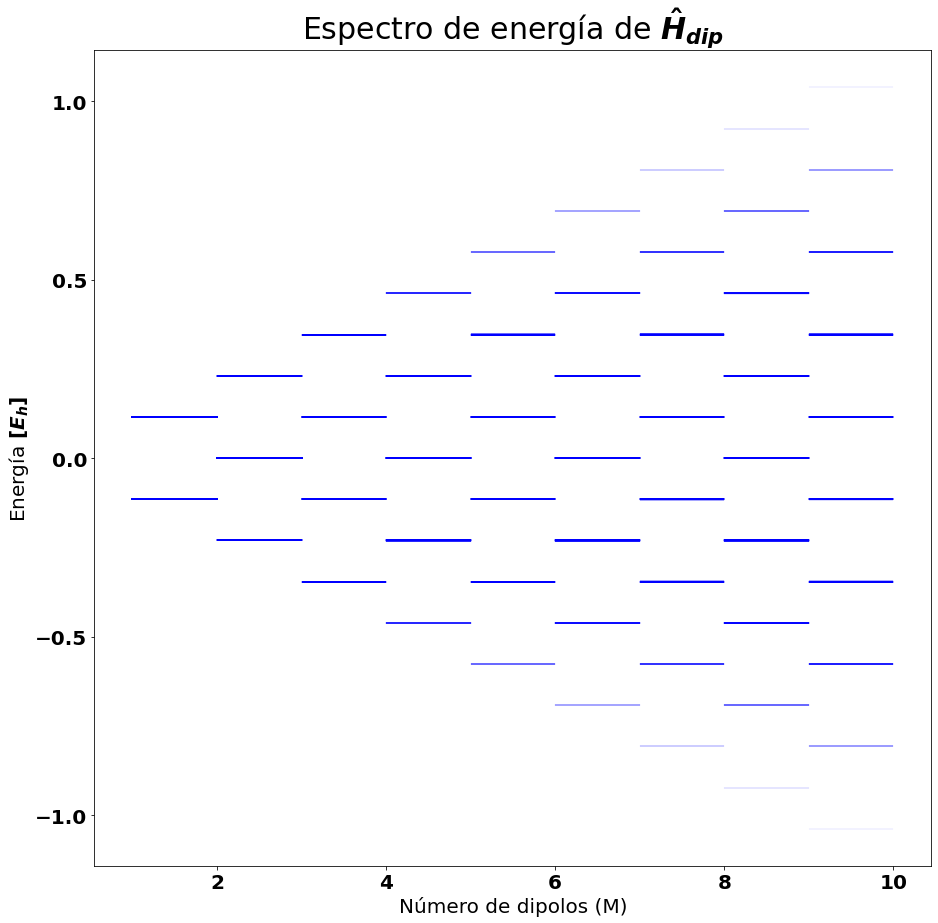

In [17]:
M=9
N=0
momentos=Momentos(M)
sigmas=sigmaT(M, N)

fig1,ax1=plt.subplots(1,1, figsize=(15,15))
u=1
p=2

for i in range(1, M+1):
#for i in range (M,M+1):
    U0=Hdip0(i, sigmas)
    U1=HdipI(i, momentos, sigmas,u, p)
    
    E0=np.real(np.linalg.eigvals(U0))
    E1=np.real(np.linalg.eigvals(U1))
    E2=np.real(np.linalg.eigvals(U0+U1))


    for j in range(len(E2)):
        X=[int(i), int(i+1)]
        ax1.plot(X,[E2[j],E2[j]], c='b', lw=0.1) 
        #ax1.plot(X,[E0[j],E0[j]], c='k')
        
              

ax1.set_xlabel('Número de dipolos (M)', fontsize=20)
ax1.set_ylabel(r'Energía$~[E_h]$', fontsize=20)
ax1.set_title('Espectro de energía de $\hat{H}_{dip}$', fontsize=30)

ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)


plt.show()

![Triangulo de pascal](TPascal.jpg)

Del espectro anterior podemos concluir que el hamiltoniano de interacción entre dipolos levanta la degeneración de los niveles de energía, de forma muy leve. 

# Vamos a estudiar ahora la parte radiativa del sistema

## Construyamos la representación matricial  para cada partícula de los operadores $\hat{\sigma}_+,\hat{\sigma}_-, \hat{\sigma}_3, \hat{a}, \hat{a}^\dagger $ en la base completa   el tamaño de las matrices es $2^M(N+1)$

En los productos tensoriales que siguen primero se pone por convención la parte de materia y por último la parte de radiación. 

En la práctica el producto tensorial se hace en dirección inversa. 

In [21]:
def aT(M,N): #función que entrega la representación matricial del operador a en la base de 
    #N fotones y M dipolos. 
    
    L=[]
    for i in range(M):
        L.append(qeye(2))
    L.append(destroy(N+1))
    a=tensor(L) #el producto tensorial lo hace desde el último hasta el primero. 
    return (np.real(np.array(a)))

Queremos establecer cuántos dipolos caben linealmente en la zona de influencia del campo de la nano esfera:


# hamiltoniano radiación-materia  en la base completa

### 

\begin{align} 
 \hat{H}_{II}= \frac{\omega_m}{2} \sum_{i=1}^{  M } \hat{\sigma}_{3j}+\omega_p \hat{a}^{\dagger} \hat{a}+3d\sqrt{\frac{6 \omega_p R^3}{
  (2\epsilon_2+1)}} \sum_{i=1}^{M} \frac{ (3 \cos \theta_{0_ik} \cos \theta_{0_id_i}-\cos \theta_{d_ik}) }{r_{0d_i}^3}(\hat{\sigma}_{+i}+\hat{\sigma}_{-i}) (\hat{a}+\hat{a}^\dagger) 
\end{align}

In [22]:
def Hrad0(a):
    return omega_p*(np.transpose(a)@a)

In [227]:
def HradI_(i, momento, sigma, P, a, q):
    
    K=np.array([[1,0,0], [0,1,0],[0,0,1]])
    k=K[q]
    H_rad1=np.zeros((sigmas[0].shape))
    
    p= P/np.linalg.norm(P)
    m=momento
    sp=sigma
    sm=np.transpose(sp)
    
    #landa=3*d*np.sqrt((6*omega_p*R**3)/(2*epsilon_2+1))
    landa= 3*d*np.sqrt((6*omega_p*R**3)/(2*epsilon_2+1))*((3*np.dot(p,k)*np.dot(p,m)-np.dot(m,k))/(np.linalg.norm(P))**3)
    H_rad1+=landa*(sm+sp)
      
    return ( np.real( H_rad1@(a+np.transpose(a))) )

In [228]:
def HradI(M, momentos, sigmas, P, a, q):
 
    K=np.array([[1,0,0], [0,1,0],[0,0,1]])
    k=K[q]
    H_rad1=np.zeros((sigmas[0].shape))
    Landa=[]
    for i in range(M):
        p= P[i] / np.linalg.norm(P[i])
        m=momentos[i]
        sp=sigmas[i]
        sm=np.transpose(sp)
        
        #landa= 3*d*np.sqrt((6*omega_p*R**3)/(2*epsilon_2+1))/(np.linalg.norm(P[i]))**3
        landa= 3*d*np.sqrt((6*omega_p*R**3)/(2*epsilon_2+1))*((3*np.dot(p,k)*np.dot(p,m)-np.dot(m,k))/(np.linalg.norm(P[i]))**3)
        Landa.append(landa)
        H_rad1+=landa*(sm+sp)
      
    return ( np.real( H_rad1@(a+np.transpose(a))), Landa )

In [234]:
#parámetros de la nano esfera
omega_p=fre(6.278) #se ingresa en eV, luego se transforma en Hartrees. 
R=a0(18e-9) #urgente determinar el R asociado a una frecuencia dada. 

#parámetros de las moléculas
omega_m=omega_p
epsilon_2=per(6.29) 

d=dby(1.411)  #el dipolo se ingresa en debyes

#paŕametros de la red

r=a0(6.27e-10)    # separación horizontal entre dipolos 

y=-(R+0.5*r)    #distancia vertical entre el centro de la nano esfera y la línea en dónde están ubicados 
#los dipolos 

In [235]:
M=1
P=posiciones(M,r,y)
p=2
q=0 #q=0=x,  q=1=y, q=2=z
u=1 

In [236]:
N=5
sigmas=sigmaT(M, N)
a=aT(M,N)

Aumentar el número de fotones para el hamiltoniano dipolar lo único que hace es aumentar la degeneración, pero no cambia los valores de la energía

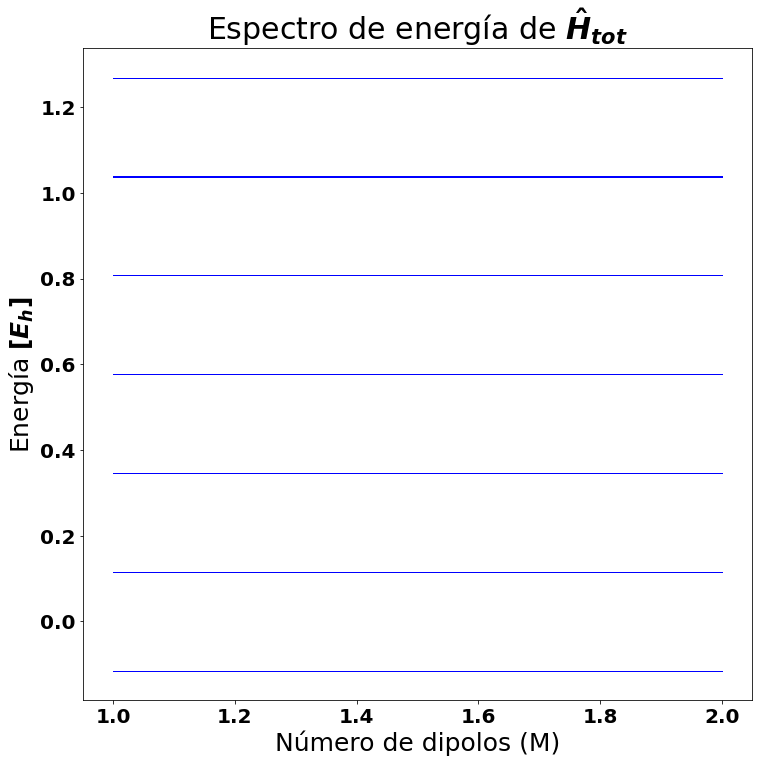

In [232]:
fig1,ax1=plt.subplots(1,1,figsize=(12,12))

for i in range (1,M+1):
#for i in range(M,M+1):

    U0=Hdip0(i, sigmas) #solo dipolos
    U1=HdipI(i, momentos, sigmas, u, p) #energía de interacción entre dipolos
    U2=U0+U1 #energía total del sistema dipolar sin radiación
    
    ###########################
    U3=Hrad0(a) #radiación en la cavidad
    RR=HradI(i, momentos, sigmas, P, a, q)
    U4=RR[0] #interacción radiación dipolos
    
    E0=np.linalg.eigvals(U0)
    E1=np.linalg.eigvals(U1)
    E2=np.linalg.eigvals(U2)
    E3=np.linalg.eigvals(U3)
    E4=np.linalg.eigvals(U4)
    E5=np.linalg.eigvals(U5)
    E6=np.linalg.eigvals(U6)
    U7=U0+U3+U4
    #U7=U0+U3+U4
    E7=np.real(np.linalg.eigvals(U7))
    
    for j in range(len(E0)):
        y=E7[j]
        X=[int(i), int(i+1)]
        ax1.plot(X,[y,y], c='blue', lw=1)
       # ax1.plot(X,[E2[j],E2[j]], c='k')
        
ax1.set_xlabel('Número de dipolos (M)', fontsize=25)
ax1.set_ylabel('Energía $[E_h]$', fontsize=25)
ax1.set_title('Espectro de energía de $\hat{H}_{tot}$', fontsize=30)


ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

#ax1.set_ylim(0.10, 0.12)

plt.show()

In [233]:
#np.sort(E7)
RR[1]

[5.1744460658624735e-05]

La distancia efectiva de acción de la nanoesfera será por lo tanto la distancia que separa el centro de la nanoesfera con el primer dipolo para el caso de $M=$.  

El hamiltoniano total y el de radiación son casi lo mismo, es decir que el hamiltoniano de interacción dipolar lo podemos considerar como una perturbación. Vamos a estudiar cómo evoluciona el valor esperado de los operadores, energía, inversión de población
número de fotones, tomando el hamiltoniano dipolar como la perturbación. 

## Evolución temporal

Para estudiar la evolución temporal lo hacemos en el cuadro de interacción y tomamos los hamiltonianos así:


\begin{align}
    \hat{H}^{(0)}&= \frac{ \omega_m}{2} \sum_{i=1}^{M} \hat{\sigma}_{3i}+ \omega_p \hat{a}^\dagger \hat{a}+\frac{d^2}{ r^3} \sum_{i=1}^{M} \sum_{j-vecinos}\left( \cos\theta_{ij}-3 \cos \theta_i \cos \theta_j \right) ( \hat{\sigma}_{i+}+\hat{\sigma}_{i-}) (\hat{\sigma}_{j+}+\hat{\sigma}_{j-}) 
\end{align}


\begin{align}
    \hat{H}^{(1)}&=3d\sqrt{\frac{6 \omega_p R^3}{(2\epsilon_2+1)}} \sum_{i=1}^{M}\sum_{\hat{k}=\hat{x}, \hat{y}, \hat{z}} \frac{ (3 \cos \theta_{0_ik} \cos \theta_{0_id_i}-\cos \theta_{d_ik}) }{r_{0d_i}^3}(\hat{\sigma}_{+i}+\hat{\sigma}_{-i}) (\hat{a}^\dagger+\hat{a})
\end{align}

In [111]:
#parámetros de la nano esfera
omega_p=fre(6.278) #se ingresa en eV, luego se transforma en Hartrees. 
R=a0(18e-9) #urgente determinar el R asociado a una frecuencia dada. 

#parámetros de las moléculas
omega_m=omega_p
epsilon_2=per(6.29) 

d=dby(1.411)  #el dipolo se ingresa en debyes

#paŕametros de la red

r=a0(6.27e-10)    # separación horizontal entre dipolos 

y=-(R+0.5*r)    #distancia vertical entre el centro de la nano esfera y la línea en dónde están ubicados 
#los dipolos 

### la eficiencia de extinción en una nanoesfera nos dice cuánta luz es "capturada" o "absorbida" por la nanoesfera en comparación con la luz que simplemente pasa a través o se dispersa

In [110]:
hc=1.98644586e-25
E=1.005846e-18

print((hc/E))

1.974900591144171e-07


In [106]:
# Definimos el tiempo
M=3
N=2
u=1
p=2
t =np.linspace(0, 42, 10000) #42tau=1f segundo
B=Base(M,N)
psi0=B[(len(B)-1)-N] #todos los subsistemas inician en el mismo estado |g1g2...gM,0>, el se más baja energía. 
sigmas=sigmaT(M, N)
P=posiciones(M,r,y)
a=aT(M, N)

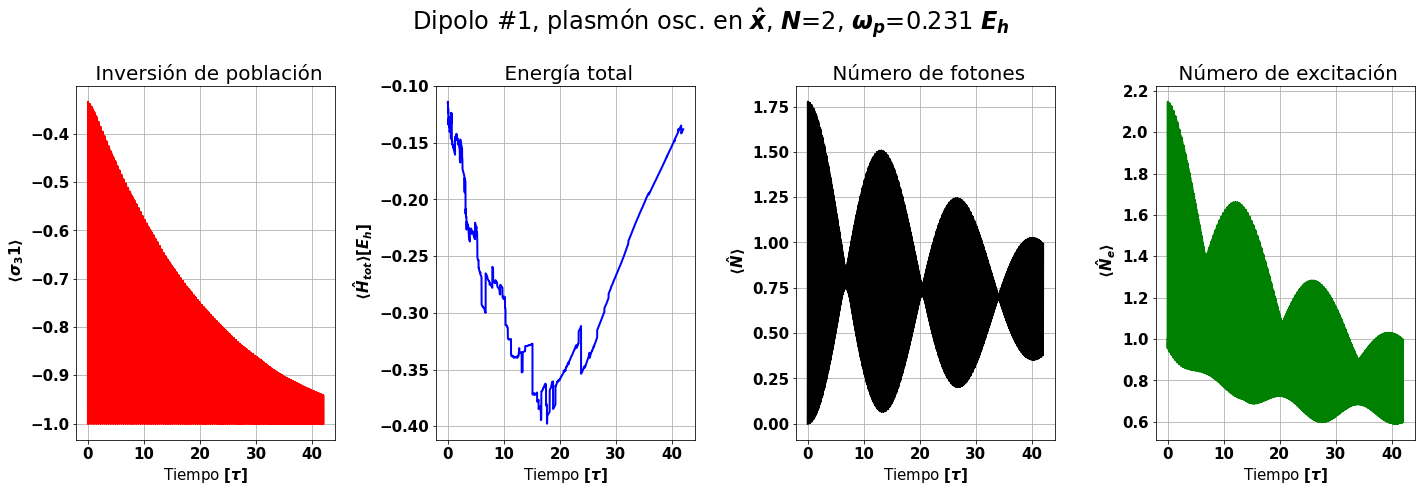

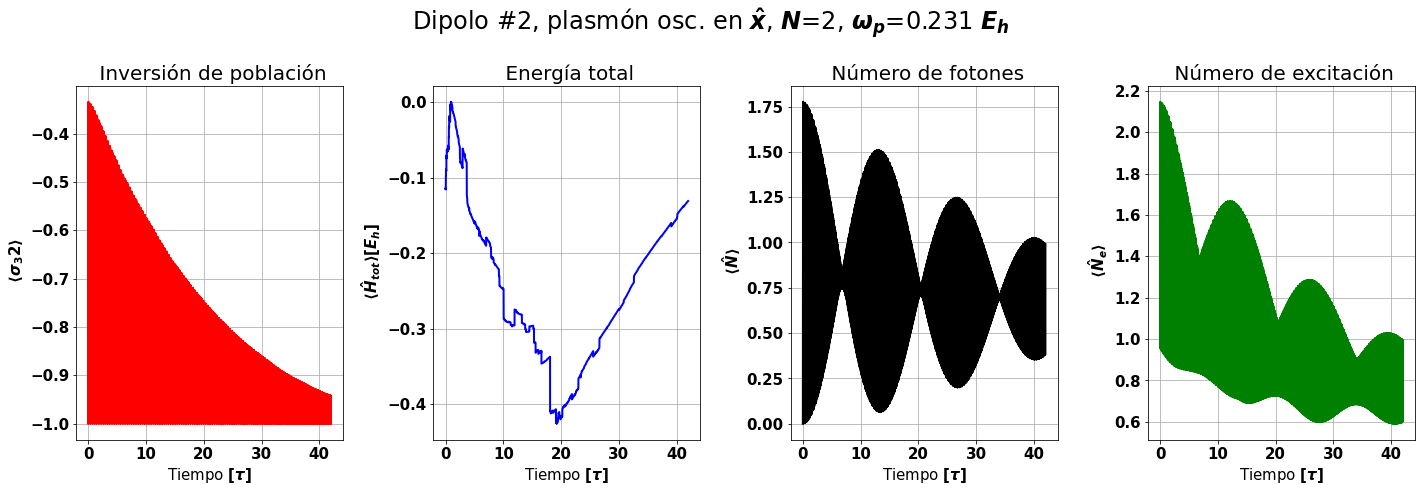

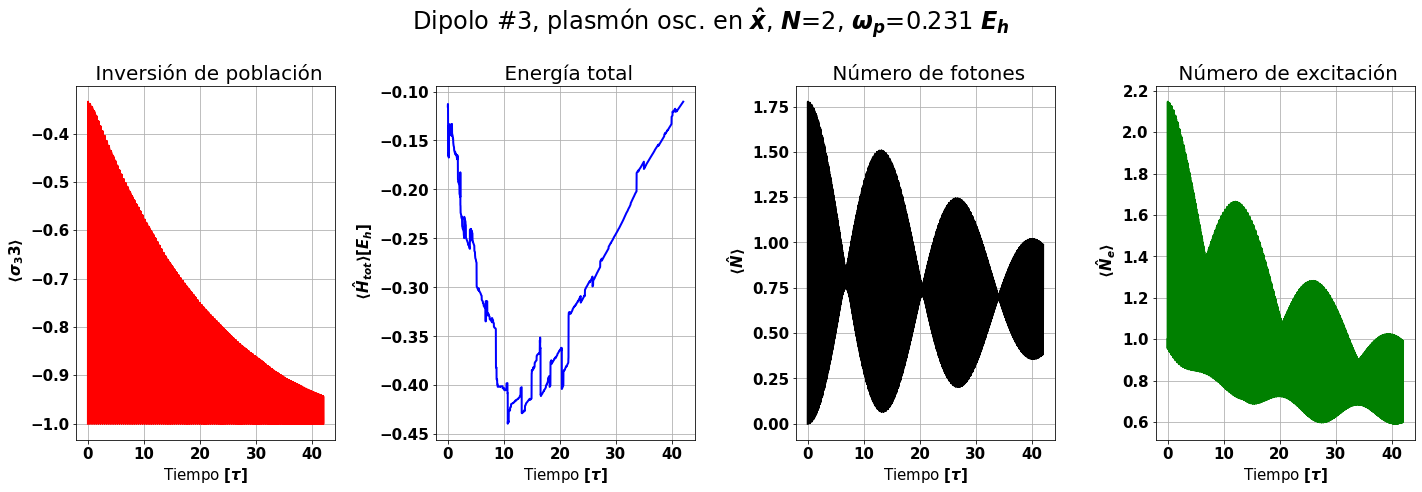

In [107]:
Q=[0]
for i in range(M):
    
    sp=sigmas[i]
    sm=np.transpose(sp)
    s3=sp@sm-sm@sp
    
    n=np.transpose(a)@a
    N_e=n+B[N]@np.transpose(B[N])

    #el hamiltoniano de cada subsistema consistiría en quitar la sumatoria, todos parten del mismo estado. 
    

    U0=Hdip0_(sp) #solo dipolos
    U1=HdipI_(i, M, sigmas, momentos, u, p) #energía de interacción entre dipolos
    U2=Hrad0(a) #radiación en la cavidad

    for q in Q:
        U3=HradI_(i, momentos[i], sp, P[i], a, q) #interacción radiación dipolos
        U4=U0+U1+U2+U3

        result=mesolve( Qobj(U4), Qobj(psi0), t, [], [Qobj(s3), Qobj(U4), Qobj(n), Qobj(N_e) ]  )

    
        fig, ax=plt.subplots(1,4, figsize=(20,7))
    
        os=['$\hat{x}$', '$\hat{y}$', '$\hat{z}$']

        fig.suptitle(r"Dipolo #{}, plasmón osc. en {}, $N$={}, $\omega_p$={} $E_h$".format(i+1, os[q], N, np.round(omega_p,3)), fontsize=24)

        ax[0].plot(t, result.expect[0], label=r"$\langle \sigma_3{} \rangle$".format(i+1),c='r',lw=2)
        ax[0].set_title(" Inversión de población", fontsize=20)
        ax[0].set_xlabel(r"Tiempo $[\tau]$")
        ax[0].set_ylabel(r" $\langle \sigma_3{} \rangle$".format(i+1))
        ax[0].grid()
        plt.tight_layout()



        ax[1].plot(t, result.expect[1], label=r"$\langle \hat{H}_{tot} \rangle$",c='b',lw=2)
        ax[1].set_title(" Energía total", fontsize=20)
        ax[1].set_xlabel(r"Tiempo $[\tau]$")
        ax[1].set_ylabel(r" $\langle \hat{H}_{tot} \rangle [E_h]$")
        ax[1].grid()
        plt.tight_layout()

        ax[2].plot(t, result.expect[2], label=r"$\langle \hat{a}^\dagger \hat{a} \rangle$",c='k',lw=2)
        ax[2].set_title(" Número de fotones", fontsize=20)
        ax[2].set_xlabel(r"Tiempo $[\tau]$")
        ax[2].set_ylabel(r" $\langle \hat{N} \rangle$")
        ax[2].grid()
        plt.tight_layout()


        ax[3].plot(t, result.expect[3], label=r"$\langle \hat{N}_e \rangle$",c='g',lw=2)
        ax[3].set_title(" Número de excitación", fontsize=20)
        ax[3].set_xlabel(r"Tiempo $[\tau]$")
        ax[3].set_ylabel(r" $\langle \hat{N}_e \rangle$")
        ax[3].grid()
        plt.tight_layout()

        plt.show()
                

# Sistema de dipolos en una cavidad sin nanoesfera. 

Para este sistema sólo debemos moficiar el hamiltoniano de interacción radiación-materia